In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import multiprocessing
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
cores = multiprocessing.cpu_count()
os.listdir()

['opencv-text-detection.zip',
 '.ipynb_checkpoints',
 'accepted_projects',
 'Andrew W. Trask - Grokking Deep Learning-Manning Publications (2019).pdf',
 'Collective_Dataset',
 'corpus',
 'corpus.zip',
 'doc2vec.ipynb',
 'doc2vec_with_kfold.html',
 'doc2vec_with_kfold.ipynb',
 'google-play-store-apps',
 'google-play-store-apps.zip',
 'helpline-of-all-sorts',
 'helpline-of-all-sorts.zip',
 'kmeans_clustering.ipynb',
 'labels.txt',
 'logistic_regression.ipynb',
 'MURA-v1.1',
 'MURA-v1.1.zip',
 'nltk',
 'opencv-text-detection',
 'Papers',
 'Papers.zip',
 'Papers_Association_Rule',
 'processed_dataset.csv',
 'Results',
 'reviews.txt',
 'sentiment_analysis_from_story_preprocessing.ipynb',
 'sentiment_dictionary.csv',
 'sklearn_test.ipynb',
 'Slides',
 'Story-categorization-using-NLP',
 'Tan.pdf',
 'Testing',
 'Udacity',
 'videodata.csv',
 'word2vec.model',
 'word2vector_test.ipynb']

In [2]:
df = pd.read_csv(os.getcwd() + "/Collective_Dataset/helpline_data.csv", usecols=[0,1])#header=None, , names=['story', 'category']

In [3]:
df.head(10)

,story,category
0,I was in class 11. I was coming back from my t...,1
1,A girl jumped on me on my friend's house! She ...,2
2,I experienced a great trauma and stress due to...,2
3,sexual harassment is a very common act that we...,2
4,"Hi, I am X from XX University, Batch 121. The...",1
5,I don't know whether I should address it as ha...,0
6,"When I got admitted in a well reputed college,...",1
7,This is normally about our areas local problem...,1
8,I went to do a free class on a famous coaching...,2
9,I was returning home after duty at about 9 PM....,2


In [4]:
df['story']

0      I was in class 11. I was coming back from my t...
1      A girl jumped on me on my friend's house! She ...
2      I experienced a great trauma and stress due to...
3      sexual harassment is a very common act that we...
4      Hi, I am X from XX University,  Batch 121. The...
                             ...                        
142    High school and junior high were hell for me. ...
143    My bullying started, or when I first noticed i...
144    I was in my class 8 year in a different school...
145    today at recess a group of senior guys came up...
146    I was just starting Middle school, and I had t...
Name: story, Length: 147, dtype: object

In [5]:
df['category']

0      1
1      2
2      2
3      2
4      1
      ..
142    1
143    1
144    1
145    1
146    1
Name: category, Length: 147, dtype: int64

In [6]:
df.shape

(147, 2)

In [7]:
df.index = range(147)

In [8]:
df.story.apply(lambda x: len(x.split(' '))).sum()

29870

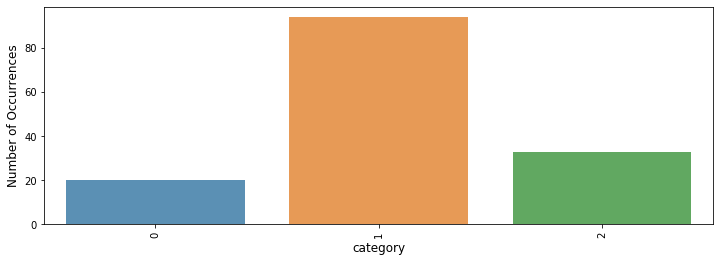

In [9]:
cnt_pro = df['category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [10]:
work_stress_counter, bullying_counter, sexual_harassment_counter = 0, 0, 0
for c in df['category']:
    if c==0:
        work_stress_counter+=1
    elif c == 1:
        bullying_counter+=1
    else:
        sexual_harassment_counter+=1
print("Work Stress Total Data Count: ", work_stress_counter)
print("Bullying Total Data Count: ", bullying_counter)
print("Sexual Harassment Total Data Count: ", sexual_harassment_counter)

Work Stress Total Data Count:  20
Bullying Total Data Count:  94
Sexual Harassment Total Data Count:  33


In [11]:
print(df.story[2])
print(df.category[2])

I experienced a great trauma and stress due to harassment issues .Moreover, I could not concentrate on my study and work for a long time
2


In [12]:
print(df.story[0])
print(df.category[0])

I was in class 11. I was coming back from my tuition classes, at a time a group of boys were passing by. I gave them much space to pass away, but one of the pulled my scarf so harshly that I couldn't balanced and I fell, in that time I became so nervous that I couldn't think about anything and got up quickly, left the place. 2 days I didn't attend my classes as well, because of the fear of 'If that happens again'. That incident left scars in my mind and I always try to avoid crowded areas. 
1


In [13]:
print(df.story[10])
print(df.category[10])

I was returning to Khulna Medical College by an auto the day after Eid. In that auto, a woman was sitting beside me and in front of her there was another woman. After some time, a man came and got seated in front of my seat. From the very fast moment, he was giving me a negative vibe. I was feeling that he was touching my knees with his knees. But it was a running auto, so I decided to stay silent. That man was about 37 - 40 years old. The moment, the woman beside me got down from the auto, that man came to sit beside me. From that time, he was trying to come close to me even though there was a lot of space in the auto. Also, he was continuously touching my waist with his elbow and behaving like he didn�â��t know anything. Then, I told him to sit away from me. He did and after some time, he left the auto.
2


In [14]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['story'] = df['story'].apply(cleanText)

In [15]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

### WITH TRAIN_TEST_SPLIT

In [16]:
train, test = train_test_split(df, test_size = .20, random_state = 2)

In [17]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)

In [18]:
train

,story,category
14,i was on my way from gabtoli to mirpur on a bu...,2
99,the first time was the day after my 20th birth...,2
128,"i worked as an office manager, and the only wo...",2
120,i have been called hurtful names and i have be...,1
45,i am 15 now and i have been bullied since grad...,1
...,...,...
75,"hi, my name is hope and like many people today...",1
43,"when i was in 7th grade, i had a semester of m...",1
22,i was fresh off of moving to a new town and en...,1
72,"hello! first of all, i'm sorry if there are a ...",1


In [19]:
len(train)

117

In [20]:
test

,story,category
91,i am currently 17 years old and a junior in hi...,1
127,"as a librarian, i've been threatened with stal...",2
3,seual harassment is a very common act that we ...,2
35,i had this one particular kid who would pick o...,1
134,my whole life i’ve had a speech impediment whe...,1
82,i have been teased all my life. i've been call...,1
129,i used to work for a call center and the men t...,2
12,i was 14 years old at that time and went to vi...,2
42,i was around 12-13 years old and at this “meet...,1
126,i feel my whole body hurting. my mental health...,0


In [21]:
len(test)

30

In [22]:
train_tagged

14     ([was, on, my, way, from, gabtoli, to, mirpur,...
99     ([the, first, time, was, the, day, after, my, ...
128    ([worked, as, an, office, manager, and, the, o...
120    ([have, been, called, hurtful, names, and, hav...
45     ([am, 15, now, and, have, been, bullied, since...
                             ...                        
75     ([hi, my, name, is, hope, and, like, many, peo...
43     ([when, was, in, 7th, grade, had, semester, of...
22     ([was, fresh, off, of, moving, to, new, town, ...
72     ([hello, first, of, all, 'm, sorry, if, there,...
15     ([as, final, year, student, completing, the, f...
Length: 117, dtype: object

In [23]:
train_tagged.values[2]

TaggedDocument(words=['worked', 'as', 'an', 'office', 'manager', 'and', 'the', 'only', 'woman', 'for', 'an', 'industrial', 'insulation', 'company', 'had', 'just', 'come', 'back', 'from', 'maternity', 'leave', 'and', 'was', 'worried', 'about', 'my', 'milk', 'supply', 'went', 'into', 'the', 'bathroom', 'to', 'pump', 'for', 'about', '15', 'minutes', 'every', 'two', 'hours', 'and', 'all', 'of', 'the', 'men', 'in', 'the', 'office', 'would', 'stand', 'in', 'the', 'break', 'area', 'right', 'in', 'front', 'of', 'the', 'bathroom', 'door', 'and', 'make', 'baby', 'crying', 'noises', 'to', 'make', 'fun', 'of', 'me', 'eventually', 'it', 'progressed', 'to', 'the', 'point', 'that', 'they', 'would', 'make', 'crying', 'noises', 'every', 'time', 'they', 'passed', 'my', 'desk', 'in', 'hopes', 'that', 'would', 'leak', 'through', 'my', 'shirt', 'they', 'would', 'also', 'make', 'comments', 'about', 'how', 'much', 'larger', 'my', 'breasts', 'were', 'since', 'having', 'baby', 'felt', 'so', 'harassed', 'and', 

In [24]:
test_tagged.values[1]

TaggedDocument(words=['as', 'librarian', "'ve", 'been', 'threatened', 'with', 'stalking', 'for', 'not', 'giving', 'my', 'phone', 'number', 'to', 'patron', "'ve", 'also', 'been', 'shown', 'naked', 'seually', 'eplicit', 'photos', 'and', 'propositioned', 'by', 'countless', 'men', 'some', 'of', 'which', 'were', 'married', 'and', 'standing', 'right', 'net', 'to', 'their', 'children', 'some', 'of', 'my', 'female', 'colleagues', 'have', 'had', 'male', 'patrons', 'waiting', 'for', 'them', 'in', 'the', 'parking', 'lot', 'after', 'work', 'and', 'they', "'ve", 'received', 'eplicit', 'messages', 'over', 'social', 'media'], tags=[2])

### PV-DBOW

In [25]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 117/117 [00:00<00:00, 778942.17it/s]


In [26]:
%%time
for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 117/117 [00:00<00:00, 557651.78it/s]

CPU times: user 209 ms, sys: 10.9 ms, total: 220 ms
Wall time: 117 ms


In [27]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [28]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [29]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [30]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 1.0
Testing F1 score: 1.0

Testing Confusion Matrix: 
[[ 5  0  0]
 [ 0 19  0]
 [ 0  0  6]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### PV-DM

In [31]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 117/117 [00:00<00:00, 384286.27it/s]


In [32]:
%%time
for epoch in range(5):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 117/117 [00:00<00:00, 733532.99it/s]

CPU times: user 264 ms, sys: 12.7 ms, total: 277 ms
Wall time: 139 ms


In [33]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

In [34]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [35]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8333333333333334
Testing F1 score: 0.8425925925925924

Testing Confusion Matrix: 
[[ 5  0  0]
 [ 2 17  0]
 [ 3  0  3]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       1.00      0.89      0.94        19
           2       1.00      0.50      0.67         6

    accuracy                           0.83        30
   macro avg       0.83      0.80      0.76        30
weighted avg       0.92      0.83      0.84        30



### Paired Model

In [36]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [37]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [38]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [39]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [40]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [41]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.7666666666666667
Testing F1 score: 0.7708708708708709

Testing Confusion Matrix: 
[[ 4  1  0]
 [ 2 17  0]
 [ 4  0  2]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.40      0.80      0.53         5
           1       0.94      0.89      0.92        19
           2       1.00      0.33      0.50         6

    accuracy                           0.77        30
   macro avg       0.78      0.68      0.65        30
weighted avg       0.86      0.77      0.77        30



### WITH K-FOLD

In [42]:
X = df['story']
print("Length: ", len(X))
print("Type: ", type(X))
print("First Ten Values:\n", X[:10])
print(X[0])

Length:  147
Type:  <class 'pandas.core.series.Series'>
First Ten Values:
 0    i was in class 11. i was coming back from my t...
1    a girl jumped on me on my friend's house! she ...
2    i eperienced a great trauma and stress due to ...
3    seual harassment is a very common act that we ...
4    hi, i am  from  university,  batch 121. there ...
5    i don't know whether i should address it as ha...
6    when i got admitted in a well reputed college,...
7    this is normally about our areas local problem...
8    i went to do a free class on a famous coaching...
9    i was returning home after duty at about 9 pm....
Name: story, dtype: object
i was in class 11. i was coming back from my tuition classes, at a time a group of boys were passing by. i gave them much space to pass away, but one of the pulled my scarf so harshly that i couldn't balanced and i fell, in that time i became so nervous that i couldn't think about anything and got up quickly, left the place. 2 days i didn't atten

In [43]:
y = df['category']
print("Length: ", len(y))
print("Type: ", type(y))
print("First Ten Values: ", y[:10])

Length:  147
Type:  <class 'pandas.core.series.Series'>
First Ten Values:  0    1
1    2
2    2
3    2
4    1
5    0
6    1
7    1
8    2
9    2
Name: category, dtype: int64


In [44]:
ten_fold = KFold(n_splits=2)
ten_fold

KFold(n_splits=2, random_state=None, shuffle=False)

In [45]:
ten_fold.get_n_splits(X)

2

### K-FOLD PV-DBOW

In [46]:
fold_no = 1
for train_index, test_index in ten_fold.split(X):
    print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    
    print("\n\n")
    fold_no+=1

Train Fold No.:  [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146]  Test Fold No.:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]


100%|██████████| 73/73 [00:00<00:00, 470329.02it/s]


Fold No.:  1
Testing accuracy 0.8513513513513513
Testing F1 score: 0.8600064350064351

Testing Confusion Matrix: 
[[ 4  2  0]
 [ 4 51  3]
 [ 1  1  8]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.94      0.88      0.91        58
           2       0.73      0.80      0.76        10

    accuracy                           0.85        74
   macro avg       0.71      0.78      0.74        74
weighted avg       0.87      0.85      0.86        74




Train Fold No.:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]  Test Fold No.:  [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115

100%|██████████| 74/74 [00:00<00:00, 347568.30it/s]


Fold No.:  2
Testing accuracy 0.5616438356164384
Testing F1 score: 0.4533710003623006

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 18  5]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.54      1.00      0.70        36
           2       0.83      0.22      0.34        23

    accuracy                           0.56        73
   macro avg       0.46      0.41      0.35        73
weighted avg       0.53      0.56      0.45        73






### K-FOLD PV-DM 

In [47]:
fold_no = 1
for train_index, test_index in ten_fold.split(X):
    print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    print("\n\n")
    fold_no+=1

Train Fold No.:  [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146]  Test Fold No.:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]


100%|██████████| 73/73 [00:00<00:00, 522498.62it/s]


Fold No.:  1
Testing accuracy 0.8243243243243243
Testing F1 score: 0.8412030187731122

Testing Confusion Matrix: 
[[ 5  0  1]
 [ 2 48  8]
 [ 1  1  8]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.98      0.83      0.90        58
           2       0.47      0.80      0.59        10

    accuracy                           0.82        74
   macro avg       0.69      0.82      0.73        74
weighted avg       0.88      0.82      0.84        74




Train Fold No.:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]  Test Fold No.:  [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115

100%|██████████| 74/74 [00:00<00:00, 193986.56it/s]


Fold No.:  2
Testing accuracy 0.6575342465753424
Testing F1 score: 0.5815691158156912

Testing Confusion Matrix: 
[[ 0  9  5]
 [ 0 34  2]
 [ 0  9 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.65      0.94      0.77        36
           2       0.67      0.61      0.64        23

    accuracy                           0.66        73
   macro avg       0.44      0.52      0.47        73
weighted avg       0.53      0.66      0.58        73






### PAIRED MODEL

In [48]:
fold_no = 1
print("Total Fold No.: 2\n\n")
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg_dbow = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dbow.fit(X_trained, y_trained)
    y_pred = logreg_dbow.predict(X_tested)
    
    print("FOR PV_DBOW: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg_dm = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dm.fit(X_trained, y_trained)
    y_pred = logreg_dm.predict(X_tested)
    
    print("FOR PV_DM: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    logreg_paired = LogisticRegression(n_jobs=1, C=1e5)
    logreg_paired.fit(X_train, y_train)
    y_pred = logreg_paired.predict(X_test)
    
    print("FOR Paired Model: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 2




100%|██████████| 73/73 [00:00<00:00, 686511.64it/s]

FOR PV_DBOW: 
Fold No.:  1
Testing accuracy 0.8378378378378378
Testing F1 score: 0.8497448497448498

Testing Confusion Matrix: 
[[ 4  1  1]
 [ 1 50  7]
 [ 1  1  8]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.96      0.86      0.91        58
           2       0.50      0.80      0.62        10

    accuracy                           0.84        74
   macro avg       0.71      0.78      0.73        74
weighted avg       0.88      0.84      0.85        74







100%|██████████| 73/73 [00:00<00:00, 303754.16it/s]


FOR PV_DM: 
Fold No.:  1
Testing accuracy 0.8378378378378378
Testing F1 score: 0.8512328288029222

Testing Confusion Matrix: 
[[ 6  0  0]
 [ 2 48  8]
 [ 1  1  8]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.98      0.83      0.90        58
           2       0.50      0.80      0.62        10

    accuracy                           0.84        74
   macro avg       0.72      0.88      0.77        74
weighted avg       0.89      0.84      0.85        74




FOR Paired Model: 
Testing accuracy 0.8648648648648649
Testing F1 score: 0.8721558557046217

Testing Confusion Matrix: 
[[ 5  1  0]
 [ 2 51  5]
 [ 1  1  8]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.96      0.88      0.92        58
           2       0.62      0.80      0.70        10

    accura

100%|██████████| 74/74 [00:00<00:00, 68713.42it/s]

FOR PV_DBOW: 
Fold No.:  2
Testing accuracy 0.547945205479452
Testing F1 score: 0.44345957561106636

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 35  1]
 [ 0 18  5]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.53      0.97      0.69        36
           2       0.71      0.22      0.33        23

    accuracy                           0.55        73
   macro avg       0.41      0.40      0.34        73
weighted avg       0.49      0.55      0.44        73







100%|██████████| 74/74 [00:00<00:00, 259080.55it/s]


FOR PV_DM: 
Fold No.:  2
Testing accuracy 0.6438356164383562
Testing F1 score: 0.5624048706240488

Testing Confusion Matrix: 
[[ 0 12  2]
 [ 0 36  0]
 [ 0 12 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.60      1.00      0.75        36
           2       0.85      0.48      0.61        23

    accuracy                           0.64        73
   macro avg       0.48      0.49      0.45        73
weighted avg       0.56      0.64      0.56        73




FOR Paired Model: 
Testing accuracy 0.5753424657534246
Testing F1 score: 0.4750998619588995

Testing Confusion Matrix: 
[[ 0 14  0]
 [ 0 36  0]
 [ 0 17  6]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.54      1.00      0.70        36
           2       1.00      0.26      0.41        23

    accura

### Decision Tree

In [49]:
fold_no = 1
print("Total Fold No.: 2\n\n")
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Entropy: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Entropy:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Entropy: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 2




100%|██████████| 73/73 [00:00<00:00, 536224.50it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  1
Testing accuracy 0.8243243243243243
Testing F1 score: 0.8267710189906987

Testing Confusion Matrix: 
[[ 2  3  1]
 [ 1 52  5]
 [ 2  1  7]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.93      0.90      0.91        58
           2       0.54      0.70      0.61        10

    accuracy                           0.82        74
   macro avg       0.62      0.64      0.63        74
weighted avg       0.83      0.82      0.83        74







100%|██████████| 73/73 [00:00<00:00, 674414.52it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  1
Testing accuracy 0.8243243243243243
Testing F1 score: 0.8458303237421706

Testing Confusion Matrix: 
[[ 6  0  0]
 [ 7 50  1]
 [ 4  1  5]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.35      1.00      0.52         6
           1       0.98      0.86      0.92        58
           2       0.83      0.50      0.62        10

    accuracy                           0.82        74
   macro avg       0.72      0.79      0.69        74
weighted avg       0.91      0.82      0.85        74




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8243243243243243
Testing F1 score: 0.8458303237421706

Testing Confusion Matrix: 
[[ 6  0  0]
 [ 7 50  1]
 [ 4  1  5]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.35      1.00      0.52         6
           1       0.98      0.86      0.92        5

100%|██████████| 74/74 [00:00<00:00, 348739.88it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  2
Testing accuracy 0.6301369863013698
Testing F1 score: 0.5476491966649674

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 13 10]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.58      1.00      0.73        36
           2       0.91      0.43      0.59        23

    accuracy                           0.63        73
   macro avg       0.50      0.48      0.44        73
weighted avg       0.57      0.63      0.55        73







100%|██████████| 74/74 [00:00<00:00, 580146.72it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  2
Testing accuracy 0.6301369863013698
Testing F1 score: 0.5476491966649674

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 13 10]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.58      1.00      0.73        36
           2       0.91      0.43      0.59        23

    accuracy                           0.63        73
   macro avg       0.50      0.48      0.44        73
weighted avg       0.57      0.63      0.55        73




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.6301369863013698
Testing F1 score: 0.5476491966649674

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 13 10]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.58      1.00      0.73        3

In [50]:
fold_no = 1
print("Total Fold No.: 2\n\n")
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Gini: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Gini:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Gini: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 2




100%|██████████| 73/73 [00:00<00:00, 353153.62it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  1
Testing accuracy 0.8108108108108109
Testing F1 score: 0.8157991056221143

Testing Confusion Matrix: 
[[ 2  3  1]
 [ 1 51  6]
 [ 2  1  7]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.93      0.88      0.90        58
           2       0.50      0.70      0.58        10

    accuracy                           0.81        74
   macro avg       0.61      0.64      0.62        74
weighted avg       0.83      0.81      0.82        74







100%|██████████| 73/73 [00:00<00:00, 235164.51it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  1
Testing accuracy 0.7297297297297297
Testing F1 score: 0.7356403132104067

Testing Confusion Matrix: 
[[ 6  0  0]
 [ 9 48  1]
 [ 9  1  0]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         6
           1       0.98      0.83      0.90        58
           2       0.00      0.00      0.00        10

    accuracy                           0.73        74
   macro avg       0.41      0.61      0.43        74
weighted avg       0.79      0.73      0.74        74




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.7297297297297297
Testing F1 score: 0.7356403132104067

Testing Confusion Matrix: 
[[ 6  0  0]
 [ 9 48  1]
 [ 9  1  0]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         6
           1       0.98      0.83      0.90        58
    

100%|██████████| 74/74 [00:00<00:00, 488016.50it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  2
Testing accuracy 0.5616438356164384
Testing F1 score: 0.5032872869795769

Testing Confusion Matrix: 
[[ 1 13  0]
 [ 1 34  1]
 [ 7 10  6]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.11      0.07      0.09        14
           1       0.60      0.94      0.73        36
           2       0.86      0.26      0.40        23

    accuracy                           0.56        73
   macro avg       0.52      0.43      0.41        73
weighted avg       0.59      0.56      0.50        73







100%|██████████| 74/74 [00:00<00:00, 475311.63it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  2
Testing accuracy 0.6301369863013698
Testing F1 score: 0.546089131882099

Testing Confusion Matrix: 
[[ 0 12  2]
 [ 0 36  0]
 [ 0 13 10]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.59      1.00      0.74        36
           2       0.83      0.43      0.57        23

    accuracy                           0.63        73
   macro avg       0.47      0.48      0.44        73
weighted avg       0.55      0.63      0.55        73




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.6301369863013698
Testing F1 score: 0.546089131882099

Testing Confusion Matrix: 
[[ 0 12  2]
 [ 0 36  0]
 [ 0 13 10]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.59      1.00      0.74        36
      

### K Nearest Neighbour with Minkowski Distance

In [51]:
fold_no = 1
print("Total Fold No.: 2\n\n")
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Minkowski Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 2




100%|██████████| 73/73 [00:00<00:00, 266247.12it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.8243243243243243
Testing F1 score: 0.8364846135116405

Testing Confusion Matrix: 
[[ 3  1  2]
 [ 2 51  5]
 [ 2  1  7]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.96      0.88      0.92        58
           2       0.50      0.70      0.58        10

    accuracy                           0.82        74
   macro avg       0.63      0.69      0.65        74
weighted avg       0.86      0.82      0.84        74







100%|██████████| 73/73 [00:00<00:00, 571239.16it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.7702702702702703
Testing F1 score: 0.8078523608798839

Testing Confusion Matrix: 
[[ 4  2  0]
 [ 9 49  0]
 [ 6  0  4]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.21      0.67      0.32         6
           1       0.96      0.84      0.90        58
           2       1.00      0.40      0.57        10

    accuracy                           0.77        74
   macro avg       0.72      0.64      0.60        74
weighted avg       0.91      0.77      0.81        74




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.7702702702702703
Testing F1 score: 0.8078523608798839

Testing Confusion Matrix: 
[[ 4  2  0]
 [ 9 49  0]
 [ 6  0  4]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.21      0.67      0.32         6
           1       0.96      0.84      0.90        

100%|██████████| 74/74 [00:00<00:00, 617054.66it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.5753424657534246
Testing F1 score: 0.4741337630942788

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 17  6]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.55      1.00      0.71        36
           2       0.86      0.26      0.40        23

    accuracy                           0.58        73
   macro avg       0.47      0.42      0.37        73
weighted avg       0.54      0.58      0.47        73







100%|██████████| 74/74 [00:00<00:00, 493447.53it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.547945205479452
Testing F1 score: 0.43143158211651367

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 19  4]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.53      1.00      0.69        36
           2       0.80      0.17      0.29        23

    accuracy                           0.55        73
   macro avg       0.44      0.39      0.33        73
weighted avg       0.51      0.55      0.43        73




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.547945205479452
Testing F1 score: 0.43143158211651367

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 19  4]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.53      1.00      0.69        

### K Nearest Neighbour with Euclidean Distance

In [52]:
fold_no = 1
print("Total Fold No.: 2\n\n")
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Euclidean Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 2




100%|██████████| 73/73 [00:00<00:00, 283241.62it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.8108108108108109
Testing F1 score: 0.828931203931204

Testing Confusion Matrix: 
[[ 3  1  2]
 [ 5 50  3]
 [ 2  1  7]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.30      0.50      0.37         6
           1       0.96      0.86      0.91        58
           2       0.58      0.70      0.64        10

    accuracy                           0.81        74
   macro avg       0.61      0.69      0.64        74
weighted avg       0.86      0.81      0.83        74







100%|██████████| 73/73 [00:00<00:00, 678900.65it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.6891891891891891
Testing F1 score: 0.7267222547596379

Testing Confusion Matrix: 
[[ 3  1  2]
 [11 47  0]
 [ 8  1  1]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.14      0.50      0.21         6
           1       0.96      0.81      0.88        58
           2       0.33      0.10      0.15        10

    accuracy                           0.69        74
   macro avg       0.48      0.47      0.42        74
weighted avg       0.81      0.69      0.73        74




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.6891891891891891
Testing F1 score: 0.7267222547596379

Testing Confusion Matrix: 
[[ 3  1  2]
 [11 47  0]
 [ 8  1  1]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.14      0.50      0.21         6
           1       0.96      0.81      0.88        

100%|██████████| 74/74 [00:00<00:00, 263255.72it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.6027397260273972
Testing F1 score: 0.5126027397260274

Testing Confusion Matrix: 
[[ 0 13  1]
 [ 0 36  0]
 [ 0 15  8]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.56      1.00      0.72        36
           2       0.89      0.35      0.50        23

    accuracy                           0.60        73
   macro avg       0.48      0.45      0.41        73
weighted avg       0.56      0.60      0.51        73







100%|██████████| 74/74 [00:00<00:00, 173298.99it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.5205479452054794
Testing F1 score: 0.3822506721290488

Testing Confusion Matrix: 
[[ 0 14  0]
 [ 0 36  0]
 [ 0 21  2]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.51      1.00      0.67        36
           2       1.00      0.09      0.16        23

    accuracy                           0.52        73
   macro avg       0.50      0.36      0.28        73
weighted avg       0.57      0.52      0.38        73




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.5205479452054794
Testing F1 score: 0.3822506721290488

Testing Confusion Matrix: 
[[ 0 14  0]
 [ 0 36  0]
 [ 0 21  2]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.51      1.00      0.67        